In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import date
import numpy as np
import mne as mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix

ELECTRODES_NUM = 35

today = date.today().strftime("%b-%d-%Y")
root_folder = f"data/{today}"

In [2]:
def product(*args, repeat=1):
    # product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
    pools = [tuple(pool) for pool in args] * repeat
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield tuple(prod)

def plot_confusion_matrix(cm, class_names,flag):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm_norm.max() / 2.
    
    for i, j in product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        color = "white" if cm_norm[i, j] > 0.34 else "black"
        plt.text(j, i, '({:.0f}%)\n {}'.format(cm_norm[i, j]*100, cm[i,j]), horizontalalignment="center", color=color, linespacing=3, fontsize='large')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def one_hot_encoder(labels, classes_num = 3):
    epochs_num = labels.shape[0]
    labels_onehot = np.zeros((epochs_num, classes_num))
    for i in range(epochs_num):
        labels_onehot[i, int(labels[i]-1)] = 1
    return labels_onehot

def print_confusion_matrix(model, data, labels_onehot):
    ###### Evaluation 
    prediction = model.predict(data)
    y_hat = np.zeros(np.shape(labels_onehot))
    for i in range(np.shape(y_hat)[0]):
        y_hat[i,np.argmax(prediction[i,:])] = 1
    delta = np.sum(abs(y_hat - labels_onehot), axis=1)
    accuracy = len(delta[delta==0])/len(delta)*100

    # Calculating Confusion Matrix
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(labels_onehot, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    class_names=["Right","Left","No Movement"]
    figure = plot_confusion_matrix(cm, class_names=class_names, flag=1)

In [3]:
# Sample data
TIME_SAMPLES_NUM = 350
NUM_IN_CLASS = 150
x_shape = (NUM_IN_CLASS,5,7,350)
x = np.concatenate((np.zeros(x_shape), np.ones(x_shape), 2 * np.ones(x_shape)))
y = np.concatenate((np.ones(NUM_IN_CLASS), 2 * np.ones(NUM_IN_CLASS), 3 * np.ones(NUM_IN_CLASS)))
y = one_hot_encoder(y)
x_train_val, x_test, y_train_val, y_test = train_test_split(x,y,test_size=0.2,stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1, stratify=y_train_val)

model = keras.Sequential([
    layers.Conv3D(20, (3,3,200), padding='valid', input_shape=(5, 7, TIME_SAMPLES_NUM, 1), activation="relu"),
    layers.Conv3D(10, (2,2,20), padding='valid', activation="relu"),
    layers.MaxPooling3D((2, 2, 50), strides=(1,1,50)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(3, activation="softmax")
])

model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

history = model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 5, 151, 20)     36020     
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 4, 132, 10)     16010     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 3, 2, 10)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 1, 3, 2, 10)      40        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

3/3 [==============================] - 0s 30ms/step


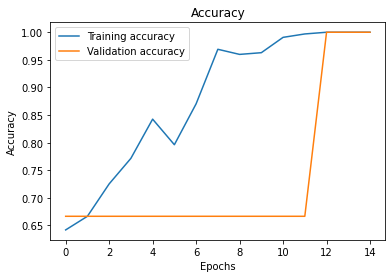

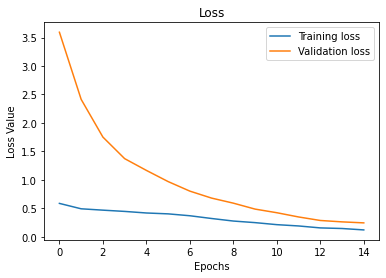

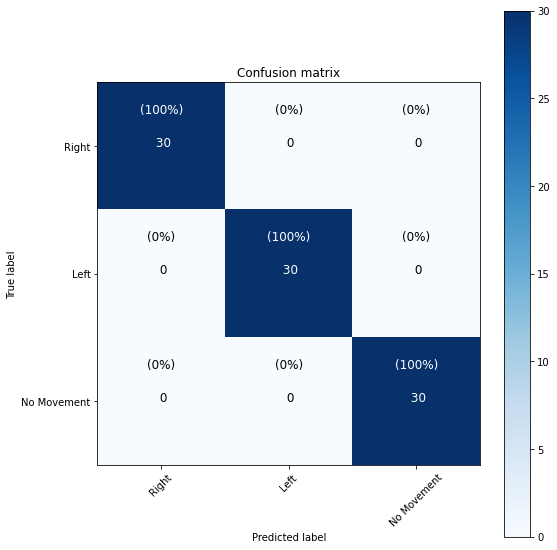

In [4]:
# Plot Accuracy graph (train set and val set)
metrics_df = pd.DataFrame(history.history)
ax = metrics_df[["accuracy", "val_accuracy"]].plot(title="Accuracy");
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy")
ax.legend(["Training accuracy", "Validation accuracy"]);

# Plot Loss graph (train set and val set)
axe = metrics_df[["loss", "val_loss"]].plot(title="Loss");
axe.set_xlabel("Epochs")
axe.set_ylabel("Loss Value")
axe.set_title("Loss")
axe.legend(["Training loss", "Validation loss"]);

print_confusion_matrix(model, x_test, y_test)

11/11 [==============================] - 0s 30ms/step


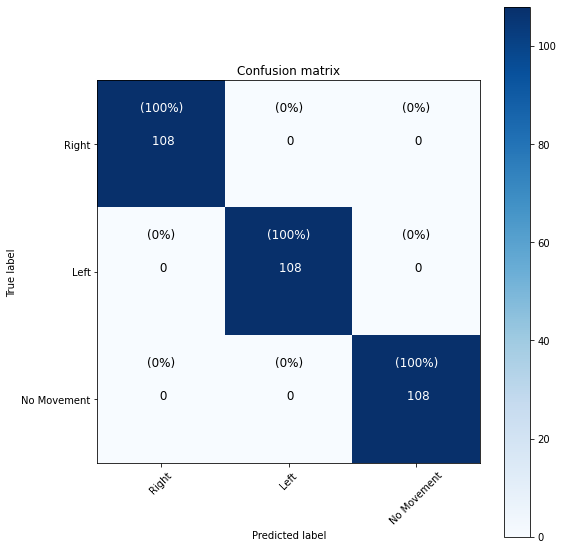

In [7]:
print_confusion_matrix(model, x_train, y_train)